# Evaluating Unsupervised Denoising Requires Unsupervised Metrics
The paper has been published at the **International Conference on Machine Learning (ICML), 2023**.

Authors: **Adria Marcos Morales\*, Matan Leibovich, Sreyas Mohan, Joshua Lawrence Vincent, Piyush Haluai, Mai Tan, Peter Crozier, Carlos Fernandez-Granda**

Full article: [arXiv:2210.05553](https://arxiv.org/pdf/2210.05553.pdf).

Official website: [https://github.com/adriamm98/umse](https://github.com/adriamm98/umse)

## Problem

In many real-world imaging applications, such as microscopy and astronomy, it is not possible to obtain ground-truth clean images. This makes it difficult to evaluate the performance of unsupervised denoising methods, which are trained on noisy data without access to ground-truth.

## Solution

We propose two novel metrics for evaluating unsupervised denoising methods: the unsupervised mean squared error (MSE) and the unsupervised peak signal-to-noise ratio (PSNR). These metrics are computed using only noisy data, and they are shown to be asymptotically consistent estimators of the supervised MSE and PSNR. This means that they provide accurate approximations of the performance of a denoising method, even when ground-truth is not available.

The proposed metrics provide a way to evaluate unsupervised denoising methods in a fair and consistent manner. They can be used to compare the performance of different denoising methods, and they can be used to track the progress of denoising methods over time. The proposed metrics are a valuable tool for the development and evaluation of unsupervised denoising methods.

## Details

* The unsupervised MSE (uMSE) is computed as the mean squared error between the noisy image and the denoised image plus a correction term to remove the bias introduced by using the noisy image as reference:

$$uMSE := \frac{1}{n}\sum_{i=1}^{n} \left(  a_i - f(y)_i\right)^2 - \frac{\left(b_i - c_i\right)^2}{2}2$$

* The unsupervised PSNR (uPSNR) is computed from the uMSE value.
* Both metrics are unbiased estimators of the supervised MSE and PSNR, indicating their ability to provide impartial approximations of a denoising method's performance.
* Both metrics are asymptotically consistent estimators of the supervised MSE and PSNR, which means that they provide accurate approximations of the performance of a denoising method as the amount of data increases.

## Use case

Let's collect an image from the DAVIS dataset, corrupt it with some Gaussian noise of different $\sigma$ values and denoise it using [UDVD](https://github.com/sreyas-mohan/udvd).

For $\sigma \in \{ 10, 25, 50, 75, 100\}$ we get the following outputs:


In [1]:
from models.udvd import BlindSpotNet
import torch
from collections import OrderedDict
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
model = BlindSpotNet()

sd = torch.load('pretrained/blind_spot_net.pt')['model'][0]
new_sd = OrderedDict()
for key in sd.keys():
    new_sd[key.replace('module.', '')] = sd[key]

model.load_state_dict(new_sd, strict=False)
model.eval()
model = model

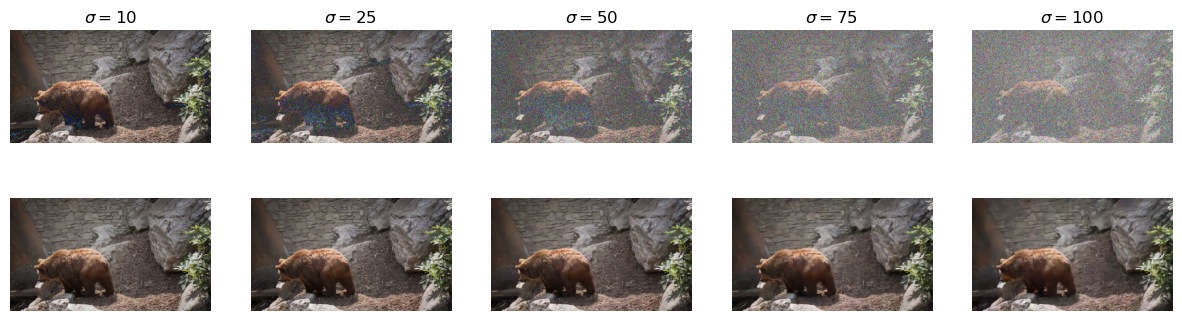

In [20]:
img = Image.open('datasets/DAVIS/JPEGImages/480p/bear/00015.jpg')
img = torch.tensor(np.array(img).astype(np.float32)).permute(2, 0, 1).unsqueeze(0)
SDs = [10, 25, 50, 75, 100]
noisy_images = []
denoising = []
fig, ax = plt.subplots(2, 5, figsize=(15, 4))
for i in range(5):
    noise = torch.randn(img.shape) * SDs[i]
    im = img + noise
    noisy_images.append(im)
    with torch.no_grad():
        pred = model(im)
    pred = pred[0]
    denoising.append(pred[0,:3])
    im = im[0].permute(1, 2, 0).detach().numpy()
    im[im>255] = 255
    im = im.astype(np.uint8)
    ax[0,i].imshow(im)
    ax[0,i].axis('off')
    ax[0,i].set_title(rf"$\sigma={SDs[i]}$")
    pred = pred[0, :3].permute(1, 2, 0).detach().numpy()
    pred[pred>255] = 255
    pred = pred.astype(np.uint8)
    ax[1,i].imshow(pred)
    ax[1,i].axis('off')
plt.show()

We can then compute the MSE values of each denoising method in an unsupervised way, comparing the values of each denoising estimation with the original image. By taking three more independently generated realizations of each original noisy image we can apply the uMSE formula and perform an estimation of the MSE value without using the original uncorrupted image.

In [25]:
def MSE(f, x):
    return torch.mean((f-x)**2)
    
def uMSE(f, a, b, c):
    return torch.mean((a-f)**2) - torch.mean((b-c)**2)/2

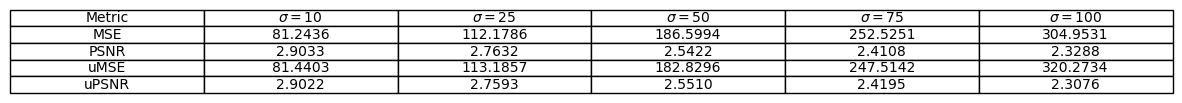

In [44]:
fig = plt.figure(figsize=(15, 1))
table_data = [["Metric"] + [rf"$\sigma={SDs[i]}$" for i in range(5)]] + [[m] for m in ['MSE', 'PSNR', 'uMSE', 'uPSNR']]
for i in range(5):
    im = denoising[i]
    table_data[1].append(f"{MSE(im, img).item():.4f}")
    table_data[2].append(f"{np.log10(255**2/MSE(im, img).item()):.4f}")

    noise = torch.randn(img.shape) * SDs[i]
    a = img + noise
    noise = torch.randn(img.shape) * SDs[i]
    b = img + noise
    noise = torch.randn(img.shape) * SDs[i]
    c = img + noise
    table_data[3].append(f"{uMSE(im, a, b, c).item():.4f}")
    table_data[4].append(f"{np.log10(255**2/uMSE(im, a, b, c).item()):.4f}")
plt.axis('off')
plt.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center')